# Imports

In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration's

In [2]:
# =====================
# CONFIGURATION
# =====================
config = {
    "model": "stft",   # Options: mobilenetv2, convnext, dct, stft, wavelet, learnable_freq
    "epochs": 60,
    "batch_size": 32,
    "lr": 1e-3,
    "early_stopping_patience": 7,
    "dropout": 0.4,
    "num_classes": 5,  # update based on dataset
    "train_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\train",
    "val_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\val",
    "test_dir": r"F:\final project\Capstone Prj\Dataset\dataset_split\test",
}
config["save_dir"] = os.path.join("models", config["model"])
os.makedirs(config["save_dir"], exist_ok=True)

config["model_path_auc"] = os.path.join(config["save_dir"], "best_auc.pth")
config["model_path_loss"] = os.path.join(config["save_dir"], "best_loss.pth")
print(f"Models will be saved in: {config['model_path_auc']}")
print(f"Models will be saved in: {config['model_path_loss']}")

Models will be saved in: models\stft\best_auc.pth
Models will be saved in: models\stft\best_loss.pth


# Transformation and DataLoader

In [3]:
# =====================
# DATA PIPELINE
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(config["train_dir"], transform=transform)
val_data = datasets.ImageFolder(config["val_dir"], transform=transform)
test_data = datasets.ImageFolder(config["test_dir"], transform=transform)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_data, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_data, batch_size=config["batch_size"], shuffle=False)

# =====================
# DEVICE
# =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}" + (f" - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

Using device: cuda - NVIDIA GeForce RTX 3050 Laptop GPU


# Model Builder

In [4]:
# =====================
# MODEL BUILDER
# =====================
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

def build_model(config):
    if config["model"] == "mobilenetv2":
        base = models.mobilenet_v2(weights="IMAGENET1K_V1")
        in_features = base.classifier[1].in_features
        base.classifier = ClassifierHead(in_features, config["num_classes"], config["dropout"])
        return base

    elif config["model"] == "convnext":
        base = models.convnext_tiny(weights="IMAGENET1K_V1")
        in_features = base.classifier[2].in_features
        base.classifier[2] = nn.Linear(in_features, config["num_classes"])
        return base

    elif config["model"] == "dct":
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(512, config["num_classes"])
        )

    elif config["model"] == "stft":
        return nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, config["num_classes"])
        )

    elif config["model"] == "wavelet":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    elif config["model"] == "learnable_freq":
        return nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, config["num_classes"])
        )

    else:
        raise ValueError(f"Unknown model type: {config['model']}")

model = build_model(config).to(device)

# =====================
# TRAINING SETUP
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Helper Function's

In [5]:
# =====================
# HELPER FUNCTIONS
# =====================
def compute_metrics(y_true, y_pred, y_prob, average="macro"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class="ovr")
    except:
        auc = 0.0
    return acc, prec, rec, f1, auc

# Training and Validation

In [6]:
best_val_loss = np.inf
best_val_auc = -np.inf
patience_counter = 0

# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [], "val_rec": [],
    "train_f1": [], "val_f1": [],
    "train_auc": [], "val_auc": []
}

# Adding SEED 
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =====================
# TRAINING LOOP
# =====================
for epoch in range(config["epochs"]):
    # -------- TRAIN --------
    model.train()
    train_loss, train_preds, train_labels, train_probs = 0, [], [], []
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        train_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        train_probs.extend(probs.cpu().detach().numpy())

    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1, train_auc = compute_metrics(
        train_labels, train_preds, train_probs
    )

    # -------- VALIDATION --------
    model.eval()
    val_loss, val_preds, val_labels, val_probs = 0, [], [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]"):
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            probs = torch.softmax(preds, dim=1)
            val_preds.extend(torch.argmax(preds, 1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1, val_auc = compute_metrics(
        val_labels, val_preds, val_probs
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    # Print results like your screenshot
    print(f"\nEpoch {epoch+1}:")
    print(f" Train -> Loss={train_loss:.4f}, Acc={train_acc:.4f}, Prec={train_prec:.4f}, "
          f"Rec={train_rec:.4f}, F1={train_f1:.4f}, AUC={train_auc:.4f}")
    print(f" Val   -> Loss={val_loss:.4f}, Acc={val_acc:.4f}, Prec={val_prec:.4f}, "
          f"Rec={val_rec:.4f}, F1={val_f1:.4f}, AUC={val_auc:.4f}")

    # Save best model based on AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), config["model_path_auc"])
        print(f"Best model (AUC) saved with AUC = {best_val_auc:.4f}")
    else:
        print(f"Validation AUC {val_auc:.4f} did not improve from {best_val_auc:.4f}")

    # Save best model based on Loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), config["model_path_loss"])
        print(f"Best model (Loss) saved with Loss = {best_val_loss:.4f}")
    else:
        print(f"Validation Loss {val_loss:.4f} did not reduced from {best_val_loss:.4f}")

    # Early stopping (based on AUC)
    if val_auc <= best_val_auc:
        patience_counter += 1
        if patience_counter >= config["early_stopping_patience"]:
            print("Early stopping triggered!")
            break


Epoch 1/60 [Val]: 100%|██████████| 84/84 [00:25<00:00,  3.27it/s]



Epoch 1:
 Train -> Loss=1.2427, Acc=0.5695, Prec=0.3641, Rec=0.1991, F1=0.1678, AUC=0.5225
 Val   -> Loss=1.1845, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5368
Best model (AUC) saved with AUC = 0.5368
Best model (Loss) saved with Loss = 1.1845


Epoch 2/60 [Val]: 100%|██████████| 84/84 [00:23<00:00,  3.58it/s]



Epoch 2:
 Train -> Loss=1.1863, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5304
 Val   -> Loss=1.1809, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5428
Best model (AUC) saved with AUC = 0.5428
Best model (Loss) saved with Loss = 1.1809


Epoch 3/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.16it/s]



Epoch 3:
 Train -> Loss=1.1837, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5368
 Val   -> Loss=1.1772, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5528
Best model (AUC) saved with AUC = 0.5528
Best model (Loss) saved with Loss = 1.1772


Epoch 4/60 [Val]: 100%|██████████| 84/84 [00:43<00:00,  1.92it/s]



Epoch 4:
 Train -> Loss=1.1801, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5434
 Val   -> Loss=1.1724, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5636
Best model (AUC) saved with AUC = 0.5636
Best model (Loss) saved with Loss = 1.1724


Epoch 5/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.10it/s]



Epoch 5:
 Train -> Loss=1.1772, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5526
 Val   -> Loss=1.1723, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5686
Best model (AUC) saved with AUC = 0.5686
Best model (Loss) saved with Loss = 1.1723


Epoch 6/60 [Val]: 100%|██████████| 84/84 [00:52<00:00,  1.58it/s]



Epoch 6:
 Train -> Loss=1.1760, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5587
 Val   -> Loss=1.1686, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5767
Best model (AUC) saved with AUC = 0.5767
Best model (Loss) saved with Loss = 1.1686


Epoch 7/60 [Val]: 100%|██████████| 84/84 [00:55<00:00,  1.51it/s]



Epoch 7:
 Train -> Loss=1.1736, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5636
 Val   -> Loss=1.1697, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5836
Best model (AUC) saved with AUC = 0.5836
Validation Loss 1.1697 did not reduced from 1.1686


Epoch 8/60 [Val]: 100%|██████████| 84/84 [00:46<00:00,  1.80it/s]



Epoch 8:
 Train -> Loss=1.1720, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5676
 Val   -> Loss=1.1649, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5863
Best model (AUC) saved with AUC = 0.5863
Best model (Loss) saved with Loss = 1.1649


Epoch 9/60 [Val]: 100%|██████████| 84/84 [00:55<00:00,  1.52it/s]



Epoch 9:
 Train -> Loss=1.1705, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5709
 Val   -> Loss=1.1636, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5899
Best model (AUC) saved with AUC = 0.5899
Best model (Loss) saved with Loss = 1.1636


Epoch 10/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.77it/s]



Epoch 10:
 Train -> Loss=1.1700, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5739
 Val   -> Loss=1.1606, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5940
Best model (AUC) saved with AUC = 0.5940
Best model (Loss) saved with Loss = 1.1606


Epoch 11/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.84it/s]



Epoch 11:
 Train -> Loss=1.1682, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5783
 Val   -> Loss=1.1595, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.5979
Best model (AUC) saved with AUC = 0.5979
Best model (Loss) saved with Loss = 1.1595


Epoch 12/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.78it/s]



Epoch 12:
 Train -> Loss=1.1666, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5820
 Val   -> Loss=1.1578, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.6009
Best model (AUC) saved with AUC = 0.6009
Best model (Loss) saved with Loss = 1.1578


Epoch 13/60 [Val]: 100%|██████████| 84/84 [00:22<00:00,  3.68it/s]



Epoch 13:
 Train -> Loss=1.1663, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5809
 Val   -> Loss=1.1559, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.6062
Best model (AUC) saved with AUC = 0.6062
Best model (Loss) saved with Loss = 1.1559


Epoch 14/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.01it/s]



Epoch 14:
 Train -> Loss=1.1630, Acc=0.6148, Prec=0.1230, Rec=0.2000, F1=0.1523, AUC=0.5895
 Val   -> Loss=1.1536, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.6126
Best model (AUC) saved with AUC = 0.6126
Best model (Loss) saved with Loss = 1.1536


Epoch 15/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.11it/s]



Epoch 15:
 Train -> Loss=1.1600, Acc=0.6149, Prec=0.3230, Rec=0.2002, F1=0.1526, AUC=0.5978
 Val   -> Loss=1.1488, Acc=0.6153, Prec=0.1231, Rec=0.2000, F1=0.1524, AUC=0.6241
Best model (AUC) saved with AUC = 0.6241
Best model (Loss) saved with Loss = 1.1488


Epoch 16/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.97it/s]



Epoch 16:
 Train -> Loss=1.1550, Acc=0.6148, Prec=0.1896, Rec=0.2001, F1=0.1526, AUC=0.6112
 Val   -> Loss=1.1427, Acc=0.6157, Prec=0.2232, Rec=0.2007, F1=0.1539, AUC=0.6346
Best model (AUC) saved with AUC = 0.6346
Best model (Loss) saved with Loss = 1.1427


Epoch 17/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.47it/s]



Epoch 17:
 Train -> Loss=1.1513, Acc=0.6153, Prec=0.2120, Rec=0.2012, F1=0.1548, AUC=0.6191
 Val   -> Loss=1.1425, Acc=0.6168, Prec=0.2035, Rec=0.2029, F1=0.1584, AUC=0.6435
Best model (AUC) saved with AUC = 0.6435
Best model (Loss) saved with Loss = 1.1425


Epoch 18/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.44it/s]



Epoch 18:
 Train -> Loss=1.1455, Acc=0.6156, Prec=0.1931, Rec=0.2022, F1=0.1570, AUC=0.6254
 Val   -> Loss=1.1326, Acc=0.6168, Prec=0.1862, Rec=0.2035, F1=0.1597, AUC=0.6461
Best model (AUC) saved with AUC = 0.6461
Best model (Loss) saved with Loss = 1.1326


Epoch 19/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.48it/s]



Epoch 19:
 Train -> Loss=1.1425, Acc=0.6163, Prec=0.1957, Rec=0.2045, F1=0.1618, AUC=0.6337
 Val   -> Loss=1.1281, Acc=0.6187, Prec=0.2130, Rec=0.2084, F1=0.1690, AUC=0.6509
Best model (AUC) saved with AUC = 0.6509
Best model (Loss) saved with Loss = 1.1281


Epoch 20/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.40it/s]



Epoch 20:
 Train -> Loss=1.1383, Acc=0.6171, Prec=0.2009, Rec=0.2062, F1=0.1649, AUC=0.6366
 Val   -> Loss=1.1261, Acc=0.6217, Prec=0.2205, Rec=0.2155, F1=0.1810, AUC=0.6552
Best model (AUC) saved with AUC = 0.6552
Best model (Loss) saved with Loss = 1.1261


Epoch 21/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.55it/s]



Epoch 21:
 Train -> Loss=1.1341, Acc=0.6170, Prec=0.1925, Rec=0.2072, F1=0.1670, AUC=0.6436
 Val   -> Loss=1.1224, Acc=0.6190, Prec=0.2170, Rec=0.2091, F1=0.1703, AUC=0.6600
Best model (AUC) saved with AUC = 0.6600
Best model (Loss) saved with Loss = 1.1224


Epoch 22/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.47it/s]



Epoch 22:
 Train -> Loss=1.1327, Acc=0.6176, Prec=0.1925, Rec=0.2085, F1=0.1691, AUC=0.6452
 Val   -> Loss=1.1199, Acc=0.6213, Prec=0.2222, Rec=0.2141, F1=0.1788, AUC=0.6606
Best model (AUC) saved with AUC = 0.6606
Best model (Loss) saved with Loss = 1.1199


Epoch 23/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.61it/s]



Epoch 23:
 Train -> Loss=1.1299, Acc=0.6181, Prec=0.1962, Rec=0.2103, F1=0.1724, AUC=0.6524
 Val   -> Loss=1.1171, Acc=0.6228, Prec=0.2181, Rec=0.2183, F1=0.1853, AUC=0.6660
Best model (AUC) saved with AUC = 0.6660
Best model (Loss) saved with Loss = 1.1171


Epoch 24/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.52it/s]



Epoch 24:
 Train -> Loss=1.1276, Acc=0.6184, Prec=0.1932, Rec=0.2108, F1=0.1731, AUC=0.6550
 Val   -> Loss=1.1131, Acc=0.6220, Prec=0.2188, Rec=0.2162, F1=0.1821, AUC=0.6664
Best model (AUC) saved with AUC = 0.6664
Best model (Loss) saved with Loss = 1.1131


Epoch 25/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.36it/s]



Epoch 25:
 Train -> Loss=1.1247, Acc=0.6182, Prec=0.1906, Rec=0.2115, F1=0.1744, AUC=0.6583
 Val   -> Loss=1.1114, Acc=0.6246, Prec=0.2241, Rec=0.2231, F1=0.1927, AUC=0.6701
Best model (AUC) saved with AUC = 0.6701
Best model (Loss) saved with Loss = 1.1114


Epoch 26/60 [Val]: 100%|██████████| 84/84 [00:17<00:00,  4.67it/s]



Epoch 26:
 Train -> Loss=1.1222, Acc=0.6192, Prec=0.1935, Rec=0.2133, F1=0.1772, AUC=0.6601
 Val   -> Loss=1.1092, Acc=0.6220, Prec=0.2226, Rec=0.2156, F1=0.1812, AUC=0.6747
Best model (AUC) saved with AUC = 0.6747
Best model (Loss) saved with Loss = 1.1092


Epoch 27/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.46it/s]



Epoch 27:
 Train -> Loss=1.1197, Acc=0.6189, Prec=0.1910, Rec=0.2129, F1=0.1766, AUC=0.6632
 Val   -> Loss=1.1071, Acc=0.6250, Prec=0.2181, Rec=0.2245, F1=0.1942, AUC=0.6752
Best model (AUC) saved with AUC = 0.6752
Best model (Loss) saved with Loss = 1.1071


Epoch 28/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.41it/s]



Epoch 28:
 Train -> Loss=1.1173, Acc=0.6194, Prec=0.1909, Rec=0.2144, F1=0.1788, AUC=0.6645
 Val   -> Loss=1.1042, Acc=0.6254, Prec=0.2195, Rec=0.2252, F1=0.1953, AUC=0.6786
Best model (AUC) saved with AUC = 0.6786
Best model (Loss) saved with Loss = 1.1042


Epoch 29/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.58it/s]



Epoch 29:
 Train -> Loss=1.1167, Acc=0.6198, Prec=0.1938, Rec=0.2154, F1=0.1805, AUC=0.6666
 Val   -> Loss=1.1039, Acc=0.6246, Prec=0.2188, Rec=0.2231, F1=0.1925, AUC=0.6775
Validation AUC 0.6775 did not improve from 0.6786
Best model (Loss) saved with Loss = 1.1039


Epoch 30/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.54it/s]



Epoch 30:
 Train -> Loss=1.1154, Acc=0.6194, Prec=0.2564, Rec=0.2149, F1=0.1797, AUC=0.6658
 Val   -> Loss=1.1035, Acc=0.6243, Prec=0.2254, Rec=0.2218, F1=0.1908, AUC=0.6812
Best model (AUC) saved with AUC = 0.6812
Best model (Loss) saved with Loss = 1.1035


Epoch 31/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.32it/s]



Epoch 31:
 Train -> Loss=1.1140, Acc=0.6200, Prec=0.2570, Rec=0.2161, F1=0.1814, AUC=0.6707
 Val   -> Loss=1.0999, Acc=0.6246, Prec=0.2163, Rec=0.2231, F1=0.1923, AUC=0.6808
Validation AUC 0.6808 did not improve from 0.6812
Best model (Loss) saved with Loss = 1.0999


Epoch 32/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.28it/s]



Epoch 32:
 Train -> Loss=1.1104, Acc=0.6200, Prec=0.2564, Rec=0.2161, F1=0.1814, AUC=0.6728
 Val   -> Loss=1.0989, Acc=0.6257, Prec=0.2155, Rec=0.2259, F1=0.1960, AUC=0.6827
Best model (AUC) saved with AUC = 0.6827
Best model (Loss) saved with Loss = 1.0989


Epoch 33/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.35it/s]



Epoch 33:
 Train -> Loss=1.1097, Acc=0.6196, Prec=0.3880, Rec=0.2171, F1=0.1831, AUC=0.6758
 Val   -> Loss=1.0991, Acc=0.6231, Prec=0.2752, Rec=0.2191, F1=0.1875, AUC=0.6855
Best model (AUC) saved with AUC = 0.6855
Validation Loss 1.0991 did not reduced from 1.0989


Epoch 34/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.89it/s]



Epoch 34:
 Train -> Loss=1.1085, Acc=0.6204, Prec=0.2920, Rec=0.2177, F1=0.1840, AUC=0.6755
 Val   -> Loss=1.0961, Acc=0.6250, Prec=0.4152, Rec=0.2246, F1=0.1951, AUC=0.6870
Best model (AUC) saved with AUC = 0.6870
Best model (Loss) saved with Loss = 1.0961


Epoch 35/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.23it/s]



Epoch 35:
 Train -> Loss=1.1077, Acc=0.6204, Prec=0.3062, Rec=0.2171, F1=0.1831, AUC=0.6777
 Val   -> Loss=1.0972, Acc=0.6280, Prec=0.2151, Rec=0.2309, F1=0.2022, AUC=0.6872
Best model (AUC) saved with AUC = 0.6872
Validation Loss 1.0972 did not reduced from 1.0961


Epoch 36/60 [Val]: 100%|██████████| 84/84 [01:06<00:00,  1.27it/s]



Epoch 36:
 Train -> Loss=1.1047, Acc=0.6208, Prec=0.2363, Rec=0.2192, F1=0.1861, AUC=0.6794
 Val   -> Loss=1.0918, Acc=0.6265, Prec=0.2161, Rec=0.2274, F1=0.1979, AUC=0.6907
Best model (AUC) saved with AUC = 0.6907
Best model (Loss) saved with Loss = 1.0918


Epoch 37/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.18it/s]



Epoch 37:
 Train -> Loss=1.1037, Acc=0.6204, Prec=0.4154, Rec=0.2182, F1=0.1847, AUC=0.6818
 Val   -> Loss=1.0904, Acc=0.6291, Prec=0.2183, Rec=0.2325, F1=0.2042, AUC=0.6913
Best model (AUC) saved with AUC = 0.6913
Best model (Loss) saved with Loss = 1.0904


Epoch 38/60 [Val]: 100%|██████████| 84/84 [00:39<00:00,  2.13it/s]



Epoch 38:
 Train -> Loss=1.1033, Acc=0.6204, Prec=0.2149, Rec=0.2184, F1=0.1848, AUC=0.6818
 Val   -> Loss=1.0913, Acc=0.6287, Prec=0.2172, Rec=0.2318, F1=0.2033, AUC=0.6909
Validation AUC 0.6909 did not improve from 0.6913
Validation Loss 1.0913 did not reduced from 1.0904


Epoch 39/60 [Val]: 100%|██████████| 84/84 [00:27<00:00,  3.10it/s]



Epoch 39:
 Train -> Loss=1.1023, Acc=0.6214, Prec=0.3764, Rec=0.2204, F1=0.1880, AUC=0.6829
 Val   -> Loss=1.0895, Acc=0.6265, Prec=0.2887, Rec=0.2317, F1=0.2082, AUC=0.6943
Best model (AUC) saved with AUC = 0.6943
Best model (Loss) saved with Loss = 1.0895


Epoch 40/60 [Val]: 100%|██████████| 84/84 [00:45<00:00,  1.85it/s]



Epoch 40:
 Train -> Loss=1.0998, Acc=0.6204, Prec=0.2244, Rec=0.2186, F1=0.1856, AUC=0.6846
 Val   -> Loss=1.0884, Acc=0.6261, Prec=0.2727, Rec=0.2264, F1=0.1977, AUC=0.6932
Validation AUC 0.6932 did not improve from 0.6943
Best model (Loss) saved with Loss = 1.0884


Epoch 41/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.07it/s]



Epoch 41:
 Train -> Loss=1.1002, Acc=0.6207, Prec=0.2557, Rec=0.2190, F1=0.1858, AUC=0.6853
 Val   -> Loss=1.0868, Acc=0.6250, Prec=0.2661, Rec=0.2259, F1=0.1974, AUC=0.6954
Best model (AUC) saved with AUC = 0.6954
Best model (Loss) saved with Loss = 1.0868


Epoch 42/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.16it/s]



Epoch 42:
 Train -> Loss=1.0989, Acc=0.6216, Prec=0.3221, Rec=0.2210, F1=0.1889, AUC=0.6864
 Val   -> Loss=1.0862, Acc=0.6295, Prec=0.3000, Rec=0.2347, F1=0.2093, AUC=0.6954
Validation AUC 0.6954 did not improve from 0.6954
Best model (Loss) saved with Loss = 1.0862


Epoch 43/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.10it/s]



Epoch 43:
 Train -> Loss=1.0962, Acc=0.6214, Prec=0.3107, Rec=0.2211, F1=0.1891, AUC=0.6878
 Val   -> Loss=1.0847, Acc=0.6295, Prec=0.2755, Rec=0.2347, F1=0.2091, AUC=0.6979
Best model (AUC) saved with AUC = 0.6979
Best model (Loss) saved with Loss = 1.0847


Epoch 44/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.23it/s]



Epoch 44:
 Train -> Loss=1.0955, Acc=0.6216, Prec=0.3020, Rec=0.2222, F1=0.1907, AUC=0.6889
 Val   -> Loss=1.0818, Acc=0.6291, Prec=0.3135, Rec=0.2368, F1=0.2155, AUC=0.6990
Best model (AUC) saved with AUC = 0.6990
Best model (Loss) saved with Loss = 1.0818


Epoch 45/60 [Val]: 100%|██████████| 84/84 [01:09<00:00,  1.22it/s]



Epoch 45:
 Train -> Loss=1.0951, Acc=0.6220, Prec=0.3331, Rec=0.2227, F1=0.1919, AUC=0.6898
 Val   -> Loss=1.0811, Acc=0.6287, Prec=0.2740, Rec=0.2332, F1=0.2072, AUC=0.6994
Best model (AUC) saved with AUC = 0.6994
Best model (Loss) saved with Loss = 1.0811


Epoch 46/60 [Val]: 100%|██████████| 84/84 [00:21<00:00,  3.92it/s]



Epoch 46:
 Train -> Loss=1.0926, Acc=0.6219, Prec=0.2578, Rec=0.2220, F1=0.1899, AUC=0.6914
 Val   -> Loss=1.0808, Acc=0.6280, Prec=0.2733, Rec=0.2317, F1=0.2054, AUC=0.6986
Validation AUC 0.6986 did not improve from 0.6994
Best model (Loss) saved with Loss = 1.0808


Epoch 47/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.59it/s]



Epoch 47:
 Train -> Loss=1.0930, Acc=0.6224, Prec=0.2726, Rec=0.2238, F1=0.1932, AUC=0.6914
 Val   -> Loss=1.0841, Acc=0.6283, Prec=0.3344, Rec=0.2345, F1=0.2122, AUC=0.6986
Validation AUC 0.6986 did not improve from 0.6994
Validation Loss 1.0841 did not reduced from 1.0808


Epoch 48/60 [Val]: 100%|██████████| 84/84 [00:20<00:00,  4.06it/s]



Epoch 48:
 Train -> Loss=1.0909, Acc=0.6216, Prec=0.2380, Rec=0.2210, F1=0.1889, AUC=0.6943
 Val   -> Loss=1.0806, Acc=0.6302, Prec=0.2996, Rec=0.2395, F1=0.2175, AUC=0.7033
Best model (AUC) saved with AUC = 0.7033
Best model (Loss) saved with Loss = 1.0806


Epoch 49/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.46it/s]



Epoch 49:
 Train -> Loss=1.0905, Acc=0.6228, Prec=0.2790, Rec=0.2243, F1=0.1939, AUC=0.6931
 Val   -> Loss=1.0772, Acc=0.6287, Prec=0.3061, Rec=0.2346, F1=0.2109, AUC=0.7026
Validation AUC 0.7026 did not improve from 0.7033
Best model (Loss) saved with Loss = 1.0772


Epoch 50/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.22it/s]



Epoch 50:
 Train -> Loss=1.0910, Acc=0.6221, Prec=0.2759, Rec=0.2228, F1=0.1921, AUC=0.6935
 Val   -> Loss=1.0789, Acc=0.6324, Prec=0.3213, Rec=0.2447, F1=0.2259, AUC=0.7028
Validation AUC 0.7028 did not improve from 0.7033
Validation Loss 1.0789 did not reduced from 1.0772


Epoch 51/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.63it/s]



Epoch 51:
 Train -> Loss=1.0902, Acc=0.6216, Prec=0.2717, Rec=0.2227, F1=0.1922, AUC=0.6930
 Val   -> Loss=1.0785, Acc=0.6321, Prec=0.3070, Rec=0.2430, F1=0.2208, AUC=0.7043
Best model (AUC) saved with AUC = 0.7043
Validation Loss 1.0785 did not reduced from 1.0772


Epoch 52/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.23it/s]



Epoch 52:
 Train -> Loss=1.0867, Acc=0.6224, Prec=0.2704, Rec=0.2243, F1=0.1936, AUC=0.6977
 Val   -> Loss=1.0820, Acc=0.6269, Prec=0.2836, Rec=0.2339, F1=0.2118, AUC=0.7051
Best model (AUC) saved with AUC = 0.7051
Validation Loss 1.0820 did not reduced from 1.0772


Epoch 53/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.27it/s]



Epoch 53:
 Train -> Loss=1.0873, Acc=0.6221, Prec=0.2974, Rec=0.2245, F1=0.1949, AUC=0.6969
 Val   -> Loss=1.0744, Acc=0.6295, Prec=0.2724, Rec=0.2353, F1=0.2095, AUC=0.7060
Best model (AUC) saved with AUC = 0.7060
Best model (Loss) saved with Loss = 1.0744


Epoch 54/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.32it/s]



Epoch 54:
 Train -> Loss=1.0857, Acc=0.6233, Prec=0.2810, Rec=0.2247, F1=0.1942, AUC=0.6988
 Val   -> Loss=1.0743, Acc=0.6295, Prec=0.3193, Rec=0.2375, F1=0.2163, AUC=0.7073
Best model (AUC) saved with AUC = 0.7073
Best model (Loss) saved with Loss = 1.0743


Epoch 55/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.39it/s]



Epoch 55:
 Train -> Loss=1.0851, Acc=0.6230, Prec=0.2981, Rec=0.2265, F1=0.1978, AUC=0.6980
 Val   -> Loss=1.0734, Acc=0.6306, Prec=0.2959, Rec=0.2426, F1=0.2244, AUC=0.7065
Validation AUC 0.7065 did not improve from 0.7073
Best model (Loss) saved with Loss = 1.0734


Epoch 56/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.24it/s]



Epoch 56:
 Train -> Loss=1.0838, Acc=0.6224, Prec=0.2974, Rec=0.2258, F1=0.1975, AUC=0.6997
 Val   -> Loss=1.0732, Acc=0.6291, Prec=0.3046, Rec=0.2354, F1=0.2117, AUC=0.7081
Best model (AUC) saved with AUC = 0.7081
Best model (Loss) saved with Loss = 1.0732


Epoch 57/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.21it/s]



Epoch 57:
 Train -> Loss=1.0835, Acc=0.6228, Prec=0.2899, Rec=0.2257, F1=0.1962, AUC=0.7012
 Val   -> Loss=1.0758, Acc=0.6310, Prec=0.2873, Rec=0.2442, F1=0.2245, AUC=0.7066
Validation AUC 0.7066 did not improve from 0.7081
Validation Loss 1.0758 did not reduced from 1.0732


Epoch 58/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.21it/s]



Epoch 58:
 Train -> Loss=1.0838, Acc=0.6227, Prec=0.3065, Rec=0.2268, F1=0.1987, AUC=0.6992
 Val   -> Loss=1.0708, Acc=0.6283, Prec=0.4056, Rec=0.2338, F1=0.2104, AUC=0.7078
Validation AUC 0.7078 did not improve from 0.7081
Best model (Loss) saved with Loss = 1.0708


Epoch 59/60 [Val]: 100%|██████████| 84/84 [00:18<00:00,  4.47it/s]



Epoch 59:
 Train -> Loss=1.0816, Acc=0.6224, Prec=0.2900, Rec=0.2252, F1=0.1959, AUC=0.7005
 Val   -> Loss=1.0714, Acc=0.6283, Prec=0.3056, Rec=0.2333, F1=0.2092, AUC=0.7081
Validation AUC 0.7081 did not improve from 0.7081
Validation Loss 1.0714 did not reduced from 1.0708


Epoch 60/60 [Val]: 100%|██████████| 84/84 [00:19<00:00,  4.24it/s]


Epoch 60:
 Train -> Loss=1.0813, Acc=0.6237, Prec=0.2644, Rec=0.2279, F1=0.1998, AUC=0.7018
 Val   -> Loss=1.0679, Acc=0.6302, Prec=0.3080, Rec=0.2394, F1=0.2169, AUC=0.7093
Best model (AUC) saved with AUC = 0.7093
Best model (Loss) saved with Loss = 1.0679


# Testing and Plotting


=== Test Results ===
 Loss=1.0893, Acc=0.6243, Prec=0.4496, Rec=0.2282, F1=0.2002, AUC=0.7019, Spec=0.8126


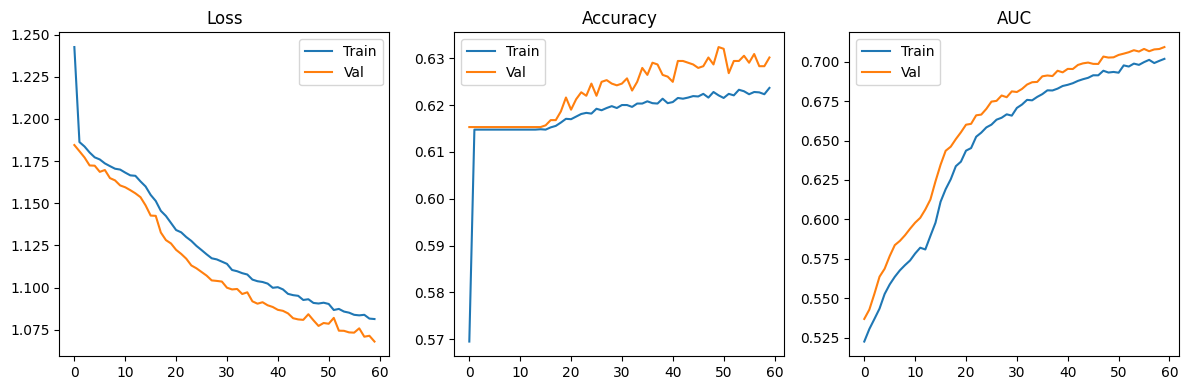

In [7]:
# =====================
# TESTING
# =====================
model.load_state_dict(torch.load(config["model_path_auc"]))
model.eval()
test_loss, test_preds, test_labels, test_probs = 0, [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
        probs = torch.softmax(preds, dim=1)
        test_preds.extend(torch.argmax(preds, 1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_loss /= len(test_loader)
test_acc, test_prec, test_rec, test_f1, test_auc = compute_metrics(test_labels, test_preds, test_probs)

# Specificity (macro-averaged)
cm = confusion_matrix(test_labels, test_preds)
tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
fp = cm.sum(axis=0) - np.diag(cm)
specificity = np.mean(tn / (tn + fp + 1e-8))

print("\n=== Test Results ===")
print(f" Loss={test_loss:.4f}, Acc={test_acc:.4f}, Prec={test_prec:.4f}, "
      f"Rec={test_rec:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}, Spec={specificity:.4f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

# =====================
# FINAL SUMMARY PLOT
# =====================
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history["train_auc"], label="Train")
plt.plot(history["val_auc"], label="Val")
plt.title("AUC")
plt.legend()

plt.tight_layout()
plt.savefig("summary.png")
plt.show()